# POTATO DISEASE CLASSIFICATION

### Importing all dependencies

In [3]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from IPython.display import HTML

import warnings
warnings.simplefilter('ignore')

### Setting all the constant

In [5]:
#batch_size = 32
img_size = 256
channel = 3
epochs = 50

### Importing data into tensorflow dataset object

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("D:\\Potato_Disease_Dataset\\Training",
                                                              seed=123,
                                                              shuffle=True,
                                                              image_size=(img_size,img_size),
                                                             )

Found 3251 files belonging to 3 classes.


In [8]:
class_name = dataset.class_names
class_name

['Early_Blight', 'Healthy', 'Late_Blight']

In [9]:
for image_batch,lables_batch in dataset.take(1):
    print(image_batch.shape)
    print(lables_batch.numpy())

(32, 256, 256, 3)
[0 0 0 2 0 2 0 2 0 2 2 0 2 1 0 0 2 1 1 1 0 0 1 2 2 1 0 1 0 2 0 2]


### Visualize some images from dataset

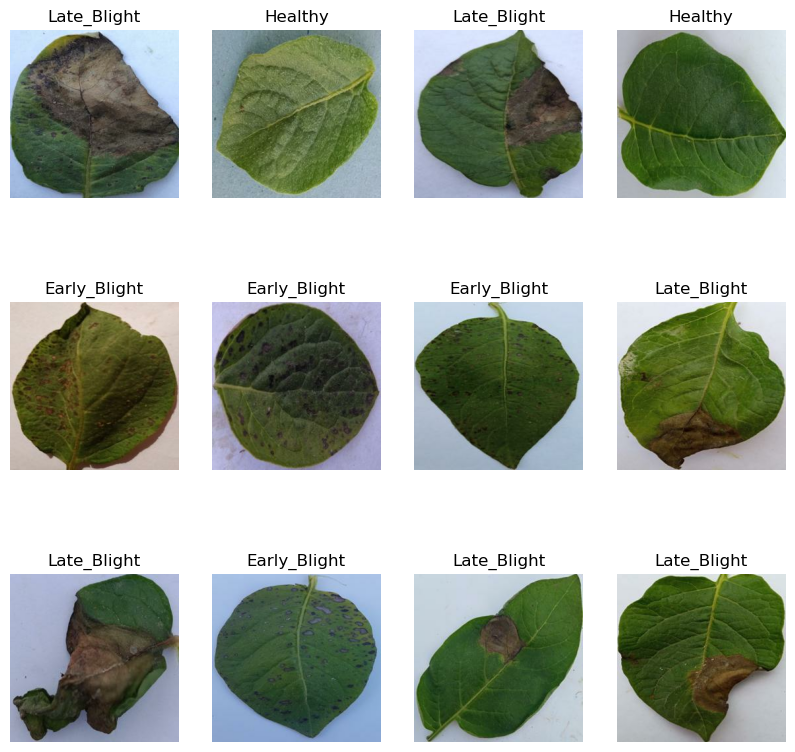

In [11]:
plt.figure(figsize=(10, 10))
for image_batch, lables_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[lables_batch[i]])
        plt.axis("off")

### Function to Split Dataset

In [13]:
len(dataset)

102

In [14]:
train_size = 0.8
len(dataset)*train_size

81.60000000000001

In [15]:
train_ds = dataset.take(81)
len(train_ds)

81

In [16]:
test_ds = dataset.skip(81)
len(test_ds)

21

In [17]:
validation_size = 0.1
len(dataset)*validation_size

10.200000000000001

In [18]:
val_ds = test_ds.take(10)
len(val_ds)

10

In [19]:
test_ds = test_ds.skip(10)
len(test_ds)

11

In [20]:
def get_dataset_partition_df(ds,train_split = 0.8,test_split = 0.1,val_split = 0.1,shuffle = True,shuffle_size = 1000):
    assert (train_split + test_split + val_split)==1

    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
    

In [21]:
train_ds, val_ds, test_ds = get_dataset_partition_df(dataset)

In [22]:
len(train_ds)

81

In [23]:
len(test_ds)

11

In [24]:
len(val_ds)

10

### Cache, Shuffle, and Prefetch the Dataset

In [26]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Building the Model

In [28]:
from tensorflow.keras import layers, models

In [29]:
resize_and_rescale = models.Sequential([
    layers.Resizing(img_size, img_size, input_shape=(img_size, img_size, channel)),  # Define input shape here
    layers.Rescaling(1./255),
])

### Data Augmentation

In [31]:
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

### Applying Data Augmentation to Train Dataset

In [33]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

###  Model Architecture

In [35]:
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),  # No input_shape here
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

In [36]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

### Compiling the model

In [38]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # Correct usage
    metrics=['accuracy']
)

In [39]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    verbose=1,
                    epochs=50
                   )

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.4174 - loss: 1.0616 - val_accuracy: 0.5344 - val_loss: 0.9683
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.5231 - loss: 0.9594 - val_accuracy: 0.5312 - val_loss: 0.9313
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 80s 987ms/step - accuracy: 0.5379 - loss: 0.9439 - val_accuracy: 0.6562 - val_loss: 0.8780
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.6451 - loss: 0.8274 - val_accuracy: 0.7500 - val_loss: 0.6294
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 73s 891ms/step - accuracy: 0.7648 - loss: 0.5944 - val_accuracy: 0.6031 - val_loss: 1.0340
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 399s 5s/step - accuracy: 0.7830 - loss: 0.5730 - val_accuracy: 0.8594 - val_loss: 0.3565
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 73s 893ms/step - accuracy: 0.8389 - loss: 0.4163 - val_accuracy: 0.8875 - val_loss: 0.2756
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 75s 929ms/step - accuracy: 0.8912 - loss: 0.2801 - val_accuracy: 0.8

In [40]:
scores = model.evaluate(test_ds)

11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 418ms/step - accuracy: 0.9770 - loss: 0.0538


In [41]:
scores

[0.06551842391490936, 0.9744318127632141]

In [42]:
history

In [43]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 81}

In [44]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [45]:
type(history.history['loss'])

list

In [46]:
len(history.history['loss'])

50

In [47]:
history.history['loss'][:5]

[1.0304981470108032,
 0.9404578804969788,
 0.9356673955917358,
 0.7833372354507446,
 0.5721968412399292]

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

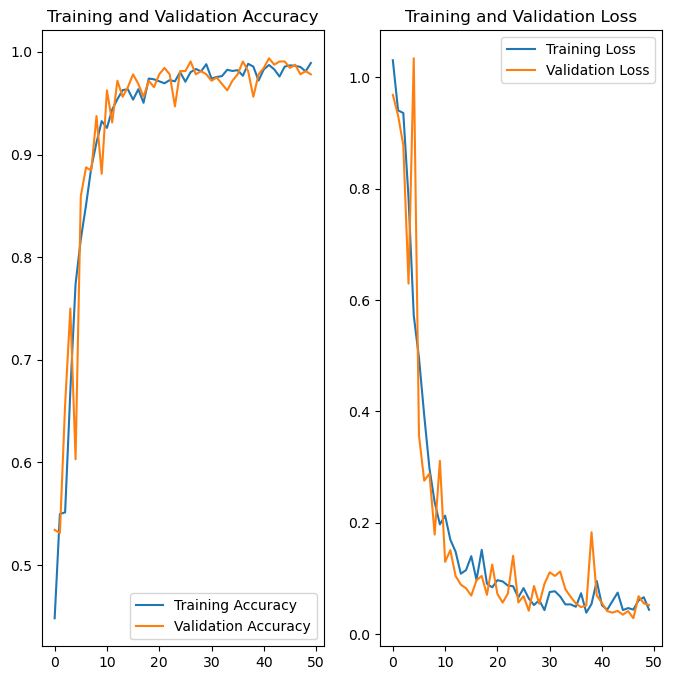

In [49]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right') 
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

First image to predict
actual label : Early_Blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 652ms/step
Predicted label : Early_Blight


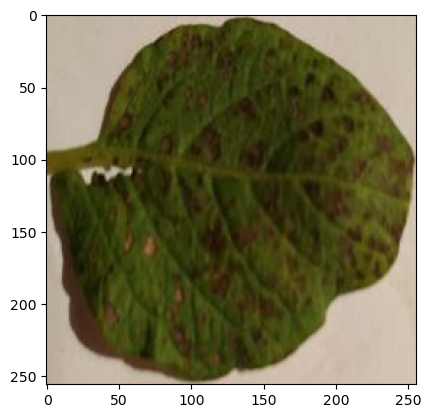

In [90]:
import numpy as np
for image_batch,labels_batch in test_ds.take(1):

    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    print('actual label :',class_name[first_label])

    batch_prediction = model.predict(image_batch)
    print('Predicted label :',class_name[np.argmax(batch_prediction[0])])

### Function for inference

In [106]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

#### Running the function on some samples

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


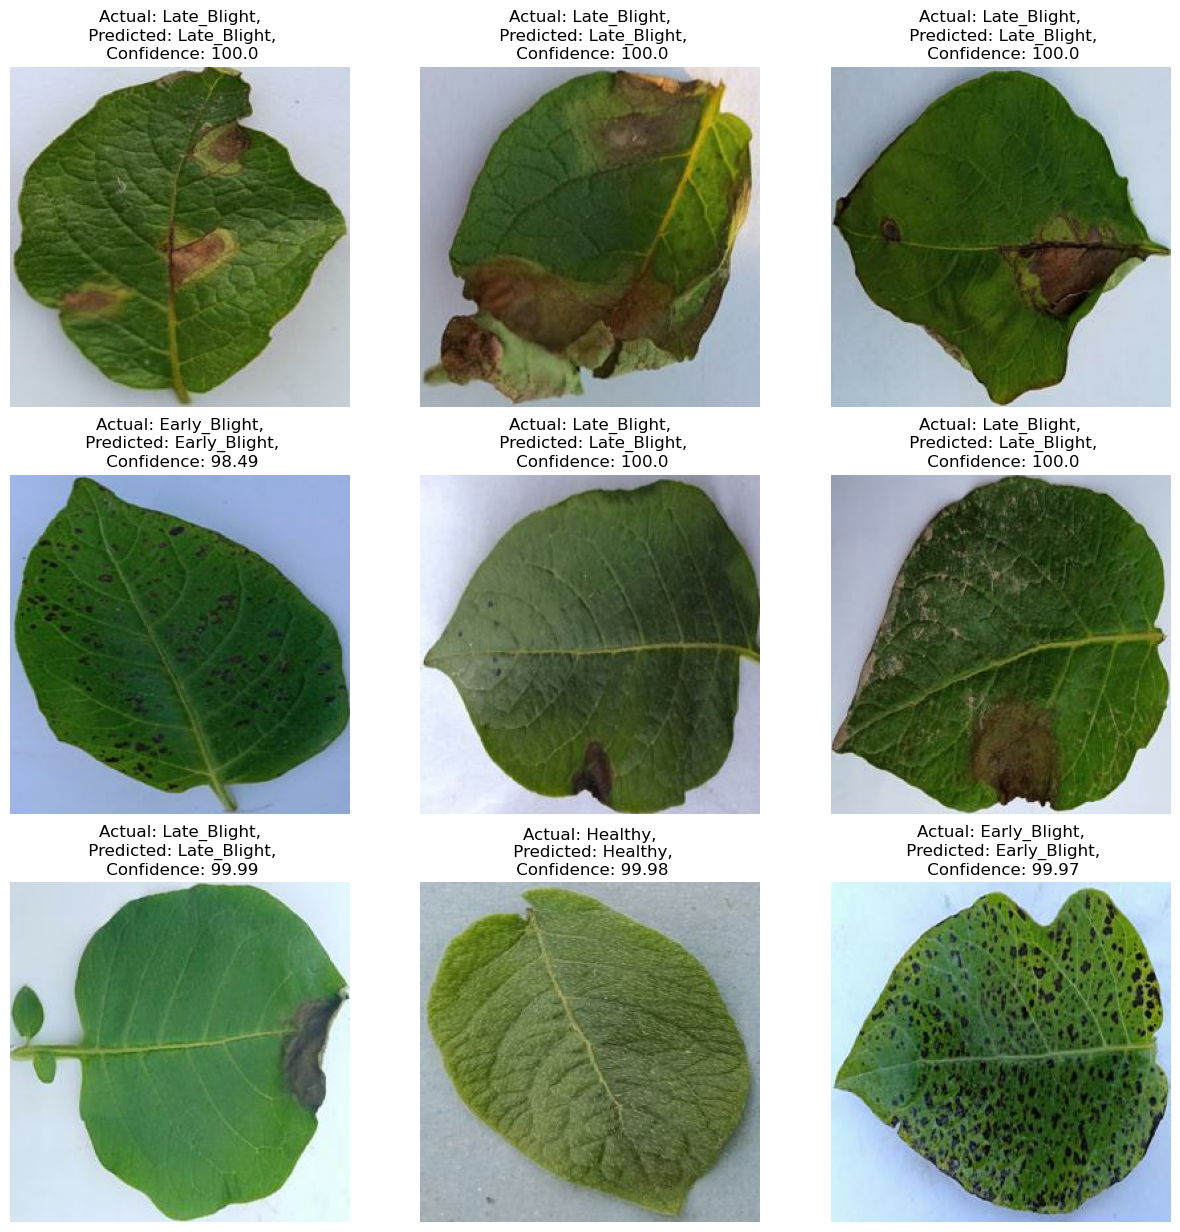

In [108]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}")
        plt.axis("off")